# What happens to bitcoin hash rate during bear markets?

* chart each bear market against hash rate over the same period

In [50]:
# Imports
%matplotlib inline
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import backtesters
reload(backtesters)
from backtesters import MABacktester # use this to calculate drawdown table

In [10]:
# Get price data 
bitcoin = quandl.get("BCHAIN/MKPRU")
bitcoin.columns = ['Close']
bitcoin = bitcoin.shift(-1) # data set has daily open, we want daily close
bitcoin = bitcoin.loc['2010-08-17':] # remove the 0's

In [51]:
# Get hashrate data
hashrate = pd.read_csv('data/btc_hash_rate.csv', index_col = 0, parse_dates = [0])

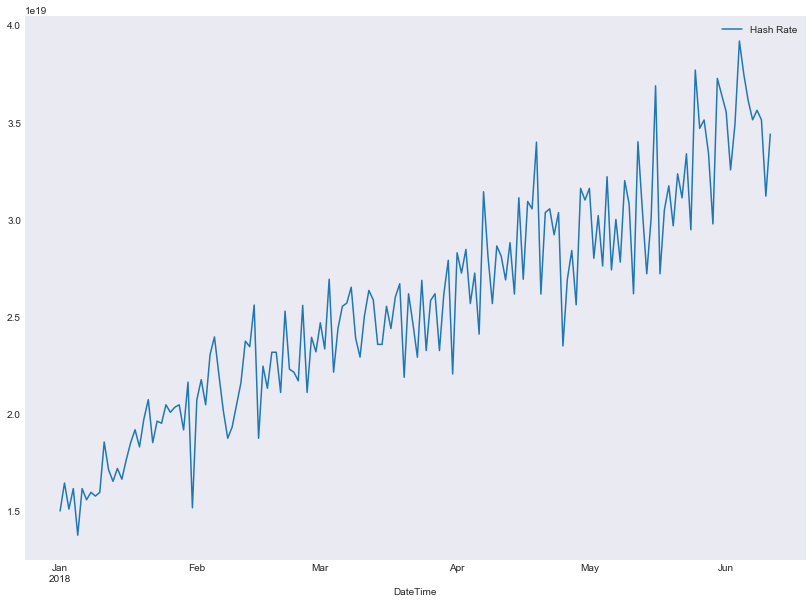

In [130]:
sns.set_style(style='dark')
hashrate.loc['2018'].plot(figsize=(14,10));

In [12]:
bitcoin_drawdowns = MABacktester(bitcoin['Close']).drawdowns(target='market')
bitcoin_drawdowns

,dd,high,low,highd,lowd,days,recoveryd,rdays
0,93.46,35.00000,2.29000,2011-06-09,2011-11-20,164 days,2013-03-03,469 days
1,84.67,1151.00000,176.50000,2013-12-03,2015-01-13,406 days,2017-02-23,772 days
2,71.49,237.99000,67.85844,2013-04-08,2013-07-04,87 days,2013-11-04,123 days
3,66.13,19498.68333,6603.87667,2017-12-16,2018-04-06,111 days,2018-06-11,66 days
4,65.20,0.17500,0.06090,2010-09-14,2010-09-16,2 days,2010-10-23,37 days
5,59.20,0.50000,0.20400,2010-11-06,2010-12-09,33 days,2011-01-31,53 days
6,39.98,7.22000,4.33333,2012-01-05,2012-02-18,44 days,2012-07-09,142 days
7,35.45,1.10000,0.71000,2011-02-09,2011-04-04,54 days,2011-04-17,13 days
8,34.80,2961.82961,1931.21430,2017-06-11,2017-07-16,35 days,2017-08-05,20 days
9,33.83,15.40000,10.18999,2012-08-16,2012-09-01,16 days,2013-01-17,138 days


In [113]:
def draw_chart(i, label_pos = [0.5, 0.5], save = False):    
    row = bitcoin_drawdowns.iloc[i]
    extra_days = 15 # add some extra days on either side
    high = row['highd']
    recovery = row['recoveryd']
    low = row['lowd']
    start = high - timedelta(days=extra_days)
    end = low + timedelta(days=extra_days)
    if row['rdays'].days > 100:
        end += timedelta(days=extra_days)
    if row['rdays'].days > 500:
        end += timedelta(days=extra_days * 4)
    if i == 3:
        end = '2018-06-12'
    fig, ax = plt.subplots(figsize=(16,10))
    ax.plot(bitcoin['Close'].loc[start:end].index, bitcoin['Close'].loc[start:end], label='Price')       
    text = "%.1f%% drop over %d days\nRecovery took %d days" % (row['dd'],row['days'].days,row['rdays'].days)
    if i == 3:
        text = "%.1f%% drop over %d days\nBeen %d days so far" % (row['dd'],row['days'].days,row['rdays'].days)
    ax.plot([high, low], [bitcoin['Close'].loc[high], bitcoin['Close'].loc[low]], 'x', color='Red', markersize=12)
    ax.legend(['Price'], loc='upper left')
    ax.text(label_pos[0], label_pos[1],text, horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, size=14)
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(hashrate.loc[start:end], color='white', alpha=0.8, label='Hash Rate')
    ax.set_ylabel('Price', color='C0', size=12)
    ax2.set_ylabel('Hash Rate', color='gray', size = 12)
    ax2.legend(['Hash Rate'])
    plt.title('Bitcoin Price and Hash Rate', size = 18)
    plt.show()
    if save:
        fig.savefig("drawdowns/hashrate/" + high.strftime("%Y-%m-%d") + '.png', dpi=100, bbox_inches='tight')
    plt.close(fig)

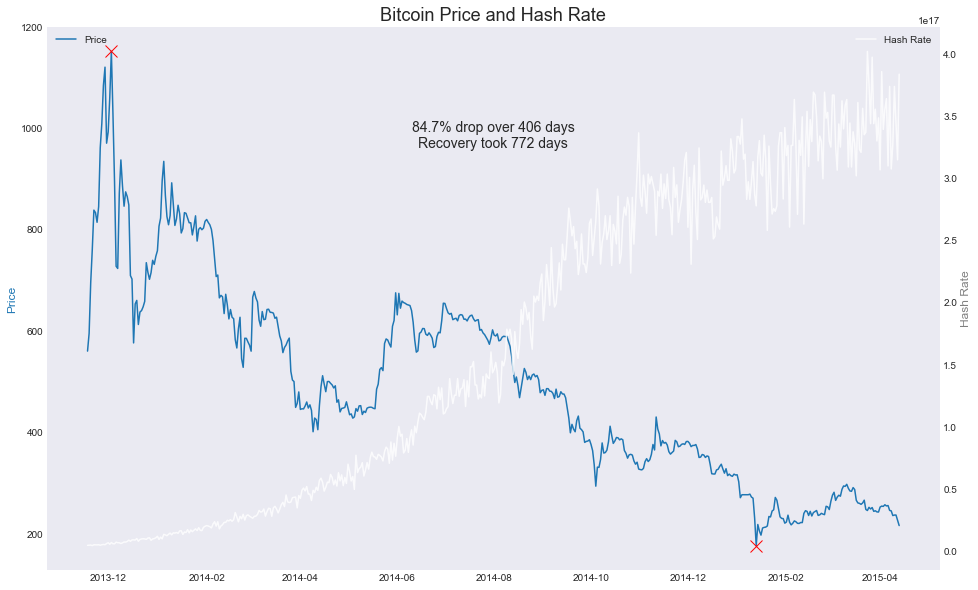

In [115]:
draw_chart(1,[0.5,0.8], save = True)

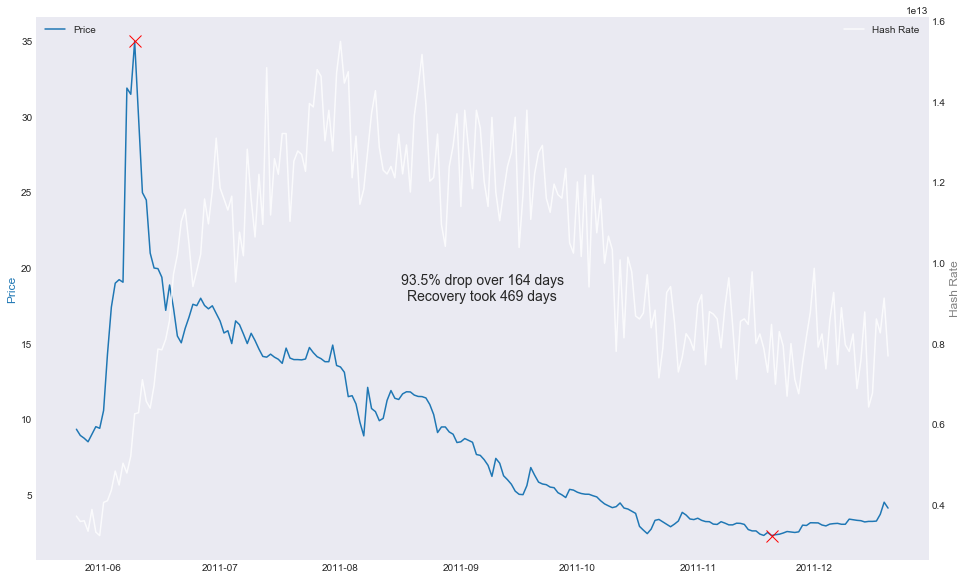

In [86]:
# plot each of the drawdowns to see the patterns
# 1 tera hash = 1 trillion hashes / sec
for i in bitcoin_drawdowns:    
    draw_chart(i, save-True)

In [37]:
bitcoin_drawdowns.sort_values('highd', ascending = True, inplace = True)
bitcoin_drawdowns.set_index('highd', inplace = True)

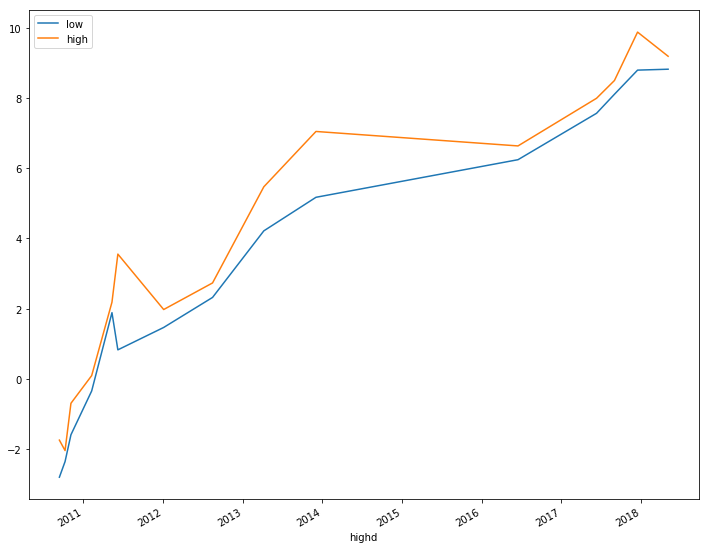

In [41]:
# on a log scale the sequence of lows in each succesive cycle are roughly a straight line (so exp growth)
# same for the sequence of highs
np.log(bitcoin_drawdowns[['low','high']]).plot(figsize=(12,10));